## Albania isolates with reference genome set

* C. Loiseau et al., “An African origin for Mycobacterium bovis,” Evol. Med. Public Heal., pp. 49–59, 2020.

In [10]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
sys.path.append('pathogenie')
from pathogenie import tools, aligners, app, trees

In [11]:
master = pd.read_csv('../mbovis_sra_master.csv')

In [22]:
reload(app)
args = {'threads':8, 'outdir': '../test_results', 'labelsep':'-',
        'input':['/storage/btbgenie/mbovis_sra/',                 
                 '/storage/btbgenie/albania/'],
        'reference': None, 'overwrite':False}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

threads 8
outdir ../test_results
labelsep -
input ['/storage/btbgenie/mbovis_sra/', '/storage/btbgenie/albania/']
reference None
overwrite False
quality 25
14 samples were loaded:
-------------
                   name      sample                                           filename  pair  read_length
0   3_S57_L001-4_R1_001  3_S57_L001  /storage/btbgenie/albania/3_S57_L001-4_R1_001....     1          149
1   3_S57_L001-4_R2_001  3_S57_L001  /storage/btbgenie/albania/3_S57_L001-4_R2_001....     2          149
2    6_S7_L001-4_R1_001   6_S7_L001  /storage/btbgenie/albania/6_S7_L001-4_R1_001.f...     1          150
3    6_S7_L001-4_R2_001   6_S7_L001  /storage/btbgenie/albania/6_S7_L001-4_R2_001.f...     2          150
4           ERR125601_1   ERR125601  /storage/btbgenie/mbovis_sra/ERR125601_1.fastq.gz     1           70
5           ERR125601_2   ERR125601  /storage/btbgenie/mbovis_sra/ERR125601_2.fastq.gz     2           70
6           ERR551023_1   ERR551023  /storage/btbgenie/mbovis_sr

## Create tree labels with meta data

In [ ]:
summ = pd.read_csv('../test_results/summary.csv')
print (summ)
reload(trees)
cols = ['Run','COUNTRY_ISOLATION','CLONAL_COMPLEX','LibraryLayout','Host','ReleaseDate','GENOME_COVERAGE','filename']
df = summ.merge(master,left_on='sample',right_on='Run',how='left').drop_duplicates('bam_file')
df.at[0:1,'COUNTRY_ISOLATION']='Albania'
df.at[0:1,'CLONAL_COMPLEX']='Unknown2'
df.at[3:4,'CLONAL_COMPLEX']='caprae'
df.at[3,'COUNTRY_ISOLATION']='Congo'
df.at[4,'COUNTRY_ISOLATION']='Germany'
labelmap = dict(zip(df['sample'],df.COUNTRY_ISOLATION))
labelmap
colors = {'Eu1': '#D362DE', 'Eu2': 'Green','Af2':'#6DA0E4','Unknown2':'gray','caprae':'orange'}
df['color'] = df.CLONAL_COMPLEX.apply(lambda x: colors[x],1)
colormap = dict(zip(df['sample'],df.color))
t,ts = trees.create_tree('../test_results/RAxML_bipartitions.variants', 'ref', labelmap, colormap)
from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
for i in colors:
    f=ts.legend.add_face(
            TextFace(text=i,fgcolor=colors[i],fsize=8),            
            column=0)
        
t.render("%%inline",tree_style=ts,w=500)
#png=t.render('../tree.png',tree_style=ts,dpi=200,w=500)

## Snippy comparison

https://github.com/tseemann/snippy

In [7]:
#tab file for multi snippy
df = W.fastq_table
x = df.reset_index().pivot(columns='pair', index='sample', values='filename')
x.to_csv('samples.tab',sep='\t')
snippycmd = '/local/snippy/bin/snippy-multi samples.tab --ref Mbovis_AF212297.fa --cpus 10 > runme.sh'

           CHR   POS REF 3_S57_L001 6_S7_L001 ERR125601 ERR551023 ERR841808 SRR1791768 SRR1791960 SRR1792002 SRR5216872 SRR5486071 SRR8063654 SRR8063665 SRR8065079
0  NC_002945.4    45   G          G         G         G         G         G          G          G          G          G          G          A          A          A
1  NC_002945.4  1057   A          G         G         G         G         G          G          G          G          G          G          G          G          G
2  NC_002945.4  2225   A          A         A         A         G         A          A          A          A          A          A          A          A          A
3  NC_002945.4  2572   A          A         A         A         A         A          A          A          A          A          A          A          A          G


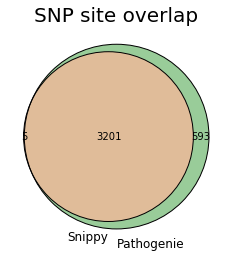

In [14]:
#read snippy snps
snippycore = pd.read_csv('../snippy_run/core.tab',sep='\t')
print (snippycore[:4])
smat = pd.read_csv('../test_results/core.txt',sep=' ',index_col=0)
print 
import matplotlib_venn
sets=[set(snippycore.POS),set(smat.index)]
matplotlib_venn.venn2(sets,set_labels=['Snippy','Pathogenie'])
ax=matplotlib_venn.venn2_circles(sets,linewidth=1)
plt.title('SNP site overlap',fontsize=20)
plt.savefig('snp_overlap_snippy.png',dpi=100)

In [ ]:
#snippy tree
treefile = trees.run_RAXML('../snippy_run/core.aln', outpath='.')
t,ts = trees.create_tree(treefile, 'Reference', labelmap, colormap)
t.render("%%inline",tree_style=ts,w=500)

## Assemble samples

In [10]:
for i,df in W.fastq_table.groupby('sample'):    
    out=os.path.join('/storage/btbgenie/assembly',i)
    if os.path.exists(out):
        shutil.copy(os.path.join(out,'scaffolds.fasta'), '/storage/btbgenie/scaffolds/%s.fa' %i)
    else:
        f1 = df.iloc[0].filename; f2 = df.iloc[1].filename
        cmd = '/local/SPAdes-3.13.0-Linux/bin/spades.py --pe1-1 %s --pe1-2 %s --careful -o %s' %(f1,f2,out)
        print (cmd)
        subprocess.check_output(cmd,shell=True)

## RD-Analysis

In [28]:
from pathogenie import rd_analysis
reload(rd_analysis)
rd_analysis.create_rd_index()
df = W.fastq_table
res = rd_analysis.find_regions(df,'../rd_aligned')

bwa index RD.fa
31.69830344651246
35.14451487601133
79.62957176781218
42.323916498848924
bwa mem -M -t 4 RD.fa /storage/btbgenie/mbovis_sra/ERR551704_1.fastq.gz /storage/btbgenie/mbovis_sra/ERR551704_2.fastq.gz | samtools view -F 0x04 -bt - | samtools sort -o ../rd_aligned/ERR551704.bam
25.2487693617546
45.04692791529111
102.24293873420844
78.31274668301171
51.20526474703119
67.25163865976717
101.27288615383499
50.24025032573718
49.98847112522362
56.56385582151506


In [ ]:
reload(rd_analysis)
X = rd_analysis.get_matrix(res, cutoff=0.15)
rd_analysis.plot_rd_matrix(X)
plt.savefig('rd_albania.png')

In [30]:
X.apply(rd_analysis.apply_rules,1)

name
3_S57_L001    Caprae
6_S7_L001      Bovis
ERR125601      Bovis
ERR551023     Caprae
ERR551704     Caprae
ERR841808      Bovis
SRR1791768     Bovis
SRR1791960     Bovis
SRR1792002     Bovis
SRR5216872     Bovis
SRR5486071     Bovis
SRR8063654    Caprae
SRR8063665     Bovis
SRR8065079     Bovis
dtype: object

In [121]:
res[res['#rname']=='RD4']

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,name,ratio
23,RD4,1,13258,1949,8043,60.66530,20.27460,34.9,58.8,3_S57_L001,0.639612
23,RD4,1,13258,503,1340,10.10710,3.74974,35.0,56.0,6_S7_L001,0.106695
23,RD4,1,13258,1885,1147,8.65138,8.96123,36.0,56.2,ERR125601,0.112536
23,RD4,1,13258,5072,13258,100.00000,54.68860,35.1,59.4,ERR551023,1.292144
23,RD4,1,13258,1108,1165,8.78715,5.62566,36.4,55.9,ERR841808,0.124884
23,RD4,1,13258,1741,1394,10.51440,14.40380,31.4,53.4,SRR1791768,0.140878
24,RD4,1,13258,1086,1375,10.37110,10.05780,33.1,54.0,SRR1791960,0.128431
23,RD4,1,13258,1321,1123,8.47036,5.02474,36.2,58.0,SRR1792002,0.098129
23,RD4,1,13258,713,1482,11.17820,7.40134,32.5,53.3,SRR5216872,0.110054
23,RD4,1,13258,1499,1375,10.37110,12.29560,36.1,52.3,SRR5486071,0.121411
